**Created: 05.04.2023**

Test my scattering programs with the Yukawa potential, as done in
https://iopscience.iop.org/article/10.1088/0305-4470/37/31/009

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import subprocess
from scipy.interpolate import interp1d
from scipy.special import riccati_jn, riccati_yn, spherical_jn, spherical_yn, hankel1, hankel2

import qdyn
from scattering import numerov_asymptotic_k, log_deriv_k, S_from_log_deriv_k

In [2]:
au_to_K = 3.157746662555312504e5
au_to_eV = 27.2113834492829731459
au_to_fm = 52.917720827883533e+3

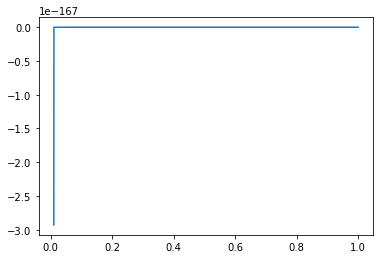

In [23]:
r, dr = np.linspace(0.01, 1, 5001, retstep=True)

mass = 459.46497670069755
V0 = -53.8e+6 / au_to_eV
a = 1.35 / au_to_fm
V = V0 * a / r * np.exp(-r/a)
Vmat = V.reshape((r.size, 1, 1))
Vmat2 = np.zeros((r.size, 2, 2))
Vmat2[:, 0,0] = V
Vmat2[:, 1,1] = V


plt.plot(r, V)

In [24]:
def run(method, kvals, l_vals, V, r):
    sigma_ch = np.zeros((len(l_vals), energies.size))
    for ik, k in enumerate(kvals):
        if method == 'numerov':
            Y_N = numerov_asymptotic_k(k, mass, V, r)
            shift = 0
        elif method == 'logderiv':
            Y_N = log_deriv_k(k, mass, V, r)
            shift = 1
        else:
            raise ValueError('Invalid method')
        S = S_from_log_deriv_k(Y_N, k, l_vals, mass, V, r, shift=shift)
        for ch in range(len(l_vals)):
            k_ch = k
            sigma_ch[ch, ik] = np.pi * np.abs(1 - S[ch, ch])**2 / k_ch**2 * (2*l_vals[ch]+1)
    sigma = sigma_ch.sum(axis=0)
    return sigma, sigma_ch

In [25]:
k = np.linspace(0.1, 1.3, 20) * au_to_fm
energies = k**2 / (2*mass)
sigma_num, sigma_ch_num = run('numerov', k, [0], Vmat, r)

In [26]:
sigma_log, sigma_ch_log = run('logderiv', k, [0], Vmat, r)

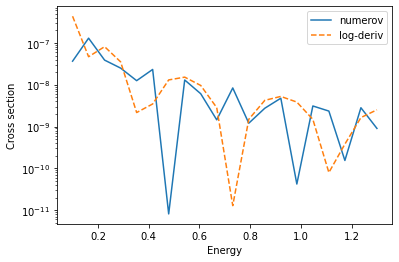

In [27]:
fig, ax = plt.subplots()
ax.plot(k /au_to_fm, sigma_num, '-', label='numerov')
ax.plot(k /au_to_fm, sigma_log, '--', label='log-deriv')
ax.set_yscale('log')
ax.set_xlabel('Energy')
ax.set_ylabel('Cross section')
ax.legend()
plt.show()

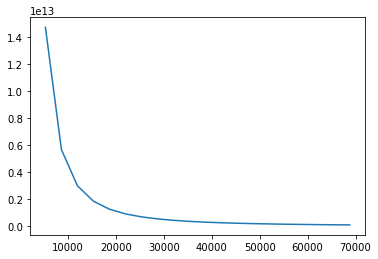

In [28]:
plt.plot(k, 4*np.pi*mass**2*V0**2 / k**2 * np.log(4*k**2/a**2 + 1))